In [13]:

import kagglehub
ananthu017_emotion_detection_fer_path = kagglehub.dataset_download('ananthu017/emotion-detection-fer')

print('Data source import complete.')

Data source import complete.


In [14]:
# Import các thư viện sử dụng trong bài
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from PIL import UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import warnings
warnings.filterwarnings('ignore')

<Axes: >

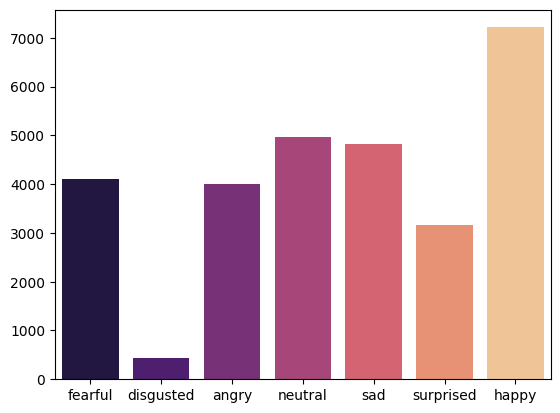

In [15]:
# Xây dựng đường dẫn tới thư mục chứa dữ liệu huấn luyện
train_dir = os.path.join(ananthu017_emotion_detection_fer_path, 'train')

# Lấy danh sách các cảm xúc từ thư mục huấn luyện
emotions = os.listdir(train_dir)

# Đếm số lượng ảnh cho mỗi cảm xúc trong thư mục huấn luyện
train_counts = []
for emotion in emotions:
    folder = os.path.join(train_dir, emotion)
    train_counts.append(len(os.listdir(folder)))

# Vẽ biểu đồ cột thể hiện số lượng ảnh cho mỗi cảm xúc trong thư mục huấn luyện
sns.barplot(x=emotions, y=train_counts, palette='magma')

<Axes: >

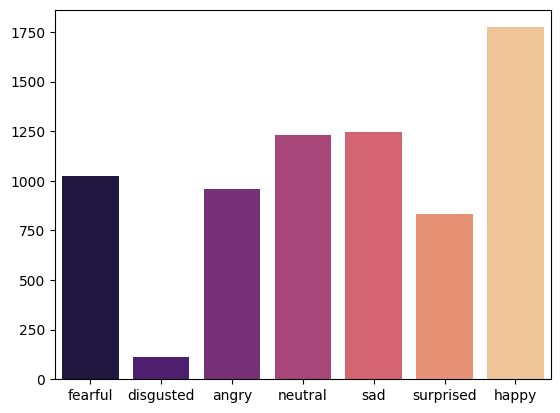

In [16]:
# Xây dựng đường dẫn tới thư mục chứa dữ liệu kiểm tra
test_dir = os.path.join(ananthu017_emotion_detection_fer_path, 'test')

# Đếm số lượng ảnh cho mỗi cảm xúc trong thư mục kiểm tra
test_counts = []
for emotion in emotions:
    folder = os.path.join(test_dir, emotion)
    test_counts.append(len(os.listdir(folder)))

# Vẽ biểu đồ cột thể hiện số lượng ảnh cho mỗi cảm xúc trong thư mục kiểm tra
sns.barplot(x=emotions, y=test_counts, palette='magma')

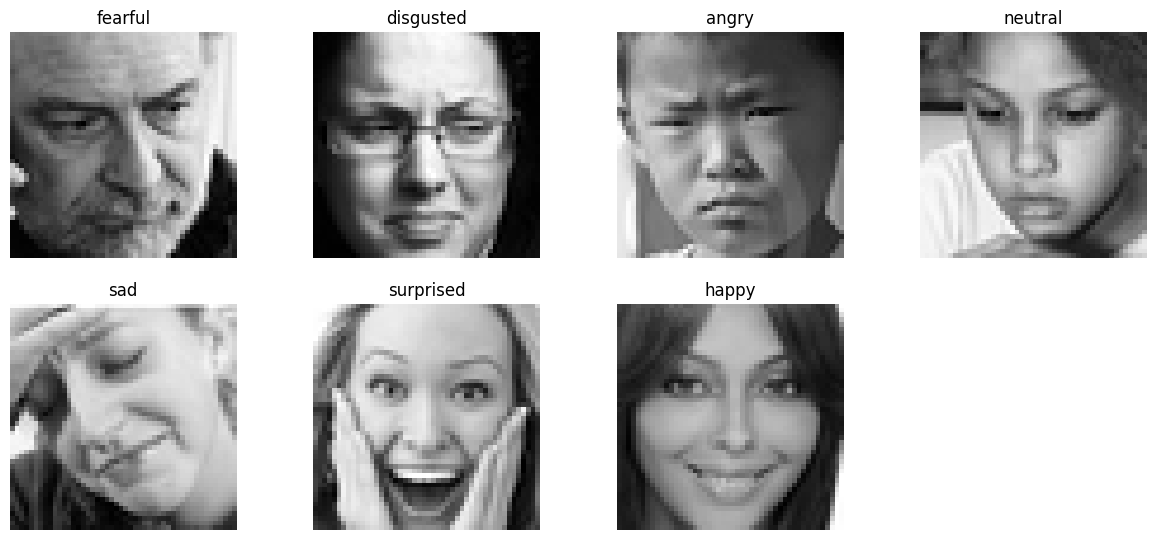

In [17]:
# Hiển thị một số ảnh mẫu từ thư mục huấn luyện
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [18]:
# Tạo các biến để tiền xử lý dữ liệu ảnh

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

# Tạo generator cho dữ liệu huấn luyện và kiểm tra
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
# Tính toán trọng số của các lớp dựa trên dữ liệu huấn luyện
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: np.float64(1.0266046844269623),
 1: np.float64(9.406618610747051),
 2: np.float64(1.0010460615781582),
 3: np.float64(0.5684387684387684),
 4: np.float64(0.8260394187886635),
 5: np.float64(0.8491274770777877),
 6: np.float64(1.293372978330405)}

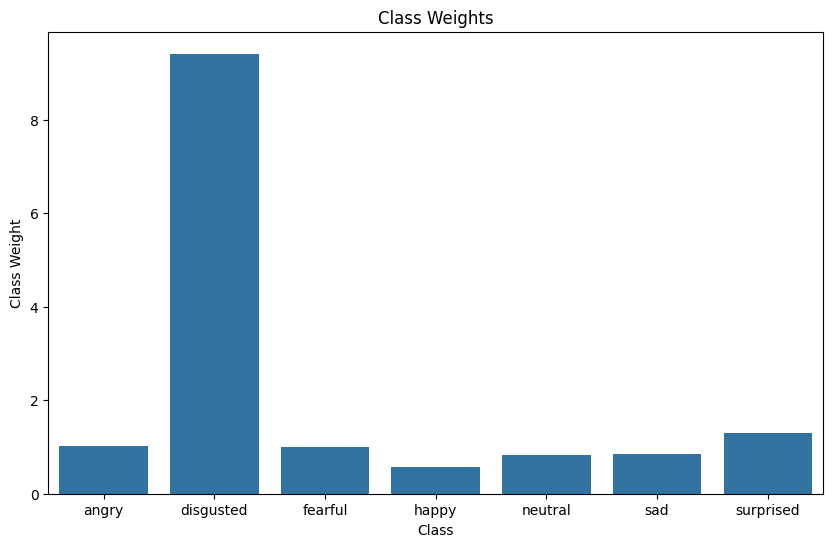

In [20]:
# Vẽ biểu đồ trọng số của các lớp
# Lấy tên các lớp từ train_generator
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=list(class_weights_dict.values()))
plt.xlabel('Class')
plt.ylabel('Class Weight')
plt.title('Class Weights')
plt.show()

In [21]:
# Xây dựng mô hình sử dụng kiến trúc ResNet50V2
input_shape = (224, 224, 3)
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

# Biên dịch mô hình
optimizer = Adamax(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,787,207 (94.56 MB)

 Trainable params: 24,737,671 (94.37 MB)

 Non-trainable params: 49,536 (193.50 KB)

In [24]:
# Huấn luyện mô hình
train_history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=25,
    validation_data=test_generator,
    validation_steps=100,
    class_weight=class_weights_dict,
)

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 194s 651ms/step - accuracy: 0.1865 - loss: 1.9067 - val_accuracy: 0.2478 - val_loss: 1.8275
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 140s 700ms/step - accuracy: 0.2598 - loss: 1.8623 - val_accuracy: 0.3131 - val_loss: 1.7540
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 712ms/step - accuracy: 0.2790 - loss: 1.7347 - val_accuracy: 0.3688 - val_loss: 1.7251
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 101s 507ms/step - accuracy: 0.3197 - loss: 1.6943 - val_accuracy: 0.4328 - val_loss: 1.5310
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 259ms/step - accuracy: 0.3442 - loss: 1.6896 - val_accuracy: 0.4403 - val_loss: 1.4990
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 710ms/step - accuracy: 0.3743 - loss: 1.6044 - val_accuracy: 0.4462 - val_loss: 1.4534
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 142s 711ms/step - accuracy: 0.4021 - loss: 1.6014 - val_accuracy: 0.4728 - val_loss: 1.3547
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 102s 509ms/step - accuracy: 0.4277 - 

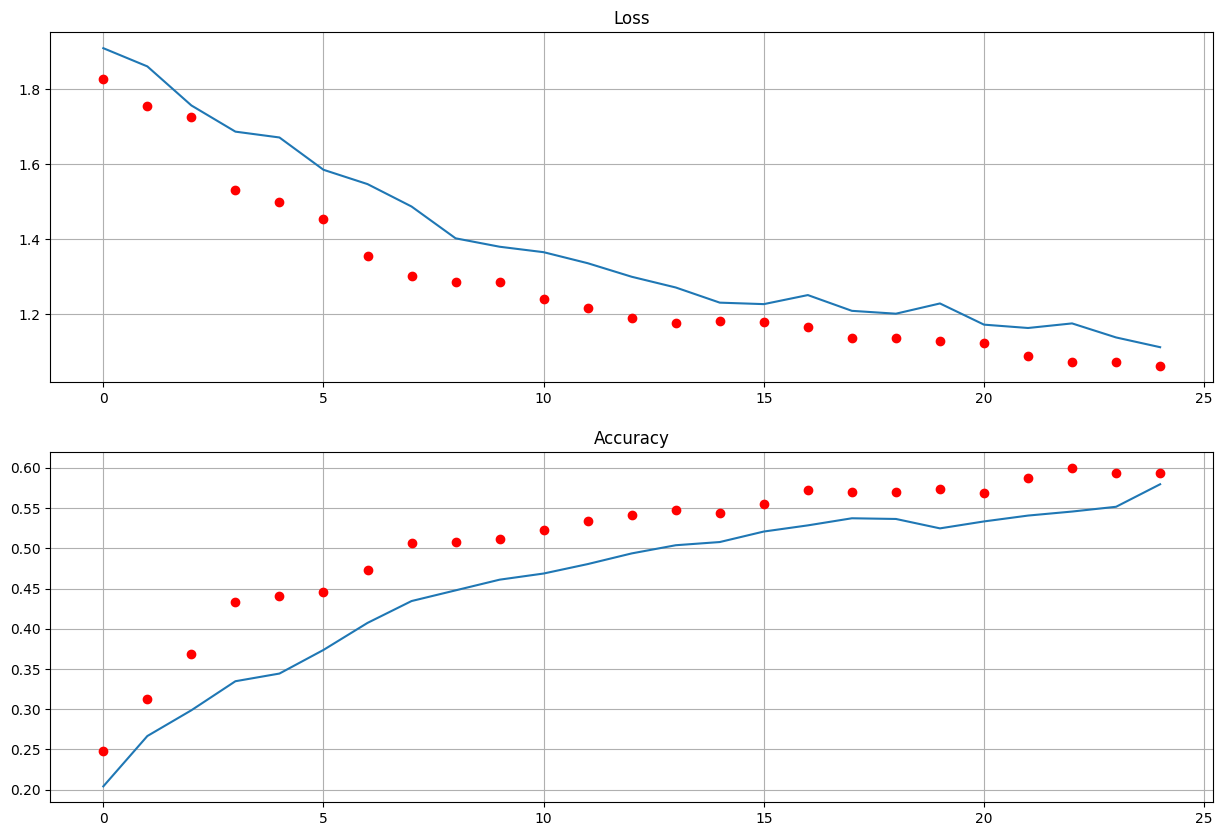

In [25]:
# Hiển thị đồ thị loss và accuracy của quá trình huấn luyện

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'], 'ro')
plt.title('Loss')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'], 'ro')
plt.title('Accuracy')
plt.grid(True)

In [26]:
# Tạo generator cho dữ liệu kiểm tra và tính toán ma trận confusion
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

Found 7178 images belonging to 7 classes.
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step


In [27]:
print(classification_report(true_labels, pred_labels, target_names=classes))

              precision    recall  f1-score   support

       angry       0.55      0.40      0.46       958
   disgusted       0.32      0.68      0.44       111
     fearful       0.43      0.21      0.28      1024
       happy       0.83      0.84      0.84      1774
     neutral       0.49      0.69      0.57      1233
         sad       0.46      0.47      0.46      1247
   surprised       0.68      0.77      0.73       831

    accuracy                           0.59      7178
   macro avg       0.54      0.58      0.54      7178
weighted avg       0.59      0.59      0.58      7178



Text(0.5, 1.0, 'Confusion Matrix')

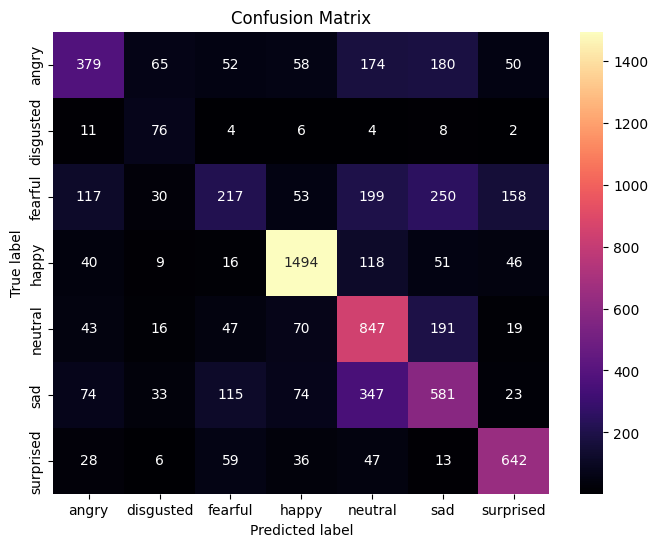

In [28]:
# Tính toán ma trận confusion
cm = confusion_matrix(true_labels, pred_labels)

# Hiển thị ma trận confusion dưới dạng heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

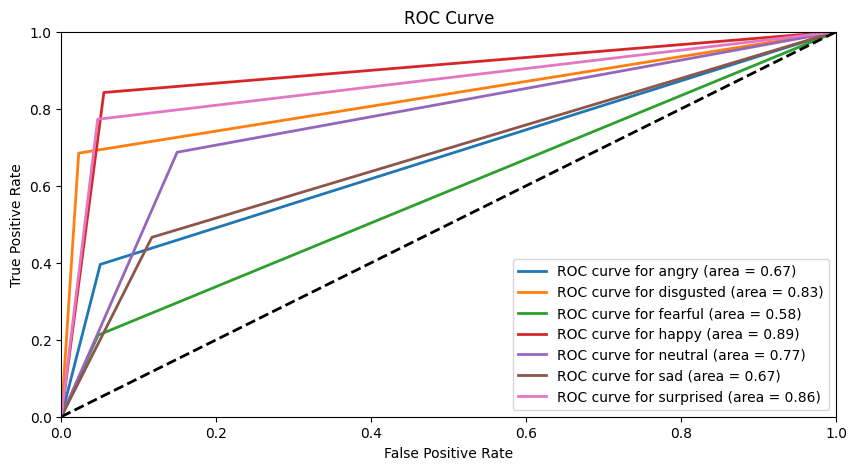

In [29]:
# One-hot encode nhãn thực tế và nhãn dự đoán để tính toán ROC curve và AUC
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

# Tính toán false positive rate (fpr), true positive rate (tpr) và area under the curve (AUC) cho từng lớp
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vẽ ROC curve và hiển thị AUC cho từng lớp
plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [30]:
# Lưu mô hình đã huấn luyện
model.save('EmotionDetector.h5')

Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im292.png - Cảm xúc dự đoán: sad
Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im1022.png - Cảm xúc dự đoán: surprised
Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im633.png - Cảm xúc dự đoán: neutral
Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im934.png - Cảm xúc dự đoán: fearful
Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im927.png - Cảm xúc dự đoán: surprised
Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im966.png - Cảm xúc dự đoán: sad
Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im662.png - Cảm xúc dự đoán: angry
Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im648.png - Cảm xúc dự đoán: sad
Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im178.png - Cảm xúc dự đoán: neutral
Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im817.png - Cảm xúc dự đoán: fearful
Ảnh: /kaggle/input/emotion-detection-fer/test/fearful/im308.png - Cảm xúc dự đoán: fearful
Ảnh: /ka

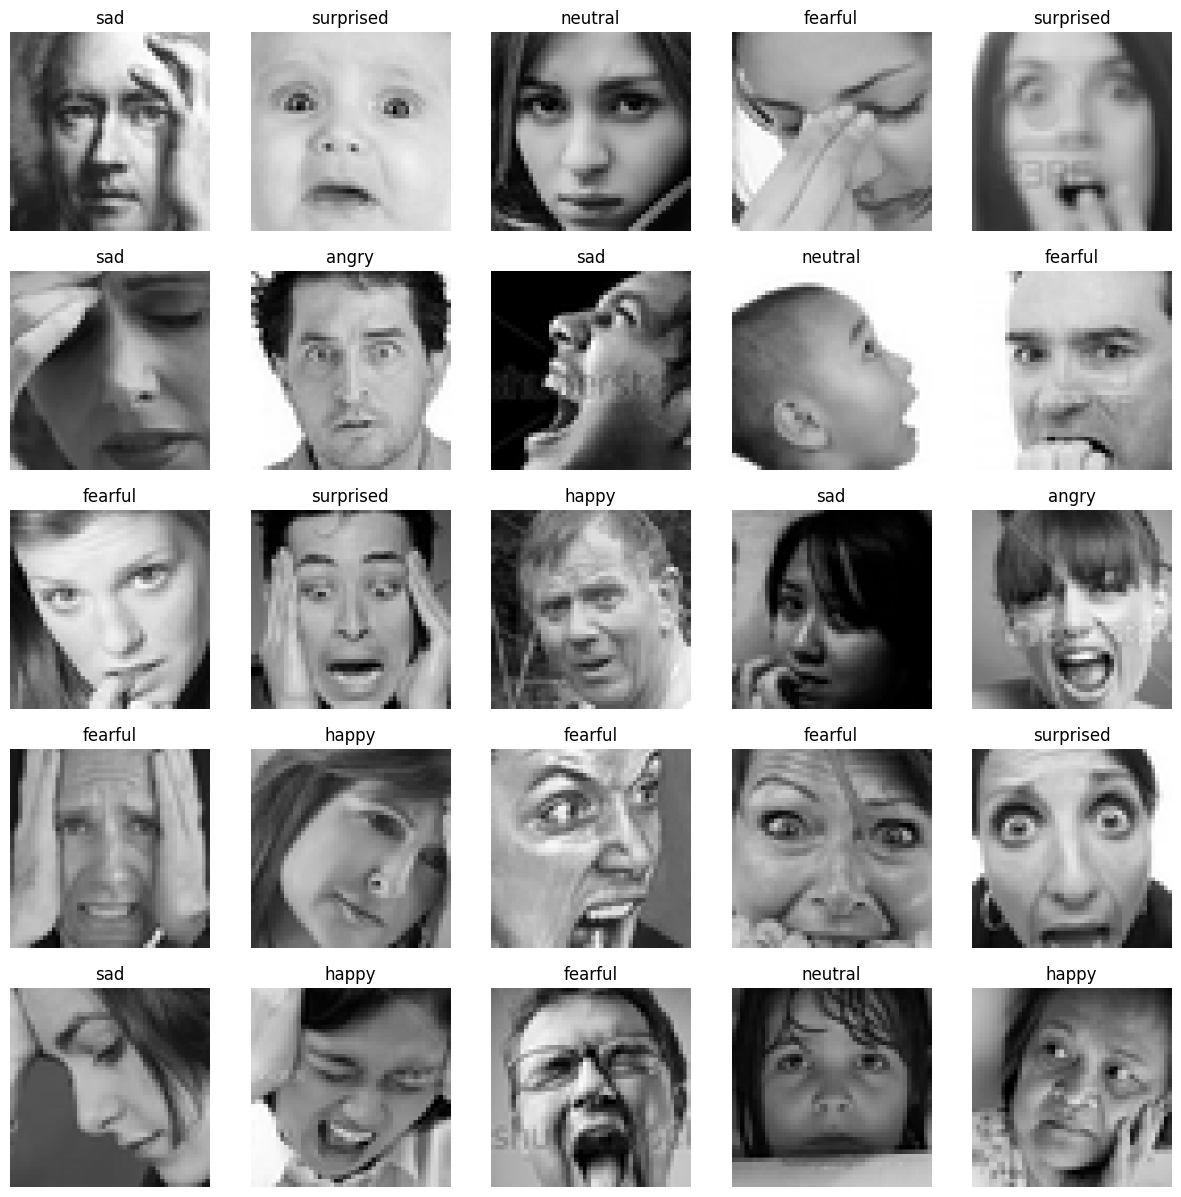

In [33]:
# ... (Các cell trước đã chạy thành công, bao gồm cả việc tải dữ liệu bằng kagglehub)

# Lưu mô hình đã huấn luyện (Nếu chưa chạy cell này)
# model.save('EmotionDetector.h5')
# print("Mô hình đã được lưu thành công.")


# Load mô hình tốt nhất đã được huấn luyện
best_model = model # best_model đã được gán sau khi huấn luyện

# Xây dựng đường dẫn tới thư mục chứa các ảnh kiểm tra
# Sử dụng lại đường dẫn test_dir đã được định nghĩa từ dataset
# test_dir = '/kaggle/input/'  # <-- Dòng này gây lỗi, cần bỏ hoặc sửa lại
test_dir = os.path.join(ananthu017_emotion_detection_fer_path, 'test') # <-- Sửa lại để trỏ đến thư mục test thật sự

# Define kích thước ảnh và các nhãn lớp
image_size = (224, 224)
class_names = list(train_generator.class_indices.keys())

# Hàm dự đoán cảm xúc cho các ảnh kiểm tra
# (Giữ nguyên hàm này hoặc dùng phiên bản đã sửa ở câu trả lời trước
# để lặp qua các thư mục con nếu cần)
def classify_emotions(test_dir, model):
    # Thêm kiểm tra xem test_dir có tồn tại và là thư mục không
    if not os.path.isdir(test_dir):
        print(f"Lỗi: Thư mục kiểm tra không tồn tại hoặc không phải là thư mục: {test_dir}")
        return []

    test_images = []
    # Lặp qua các thư mục con (các lớp cảm xúc) trong test_dir để lấy danh sách ảnh
    # Đây là cấu trúc thư mục chuẩn khi sử dụng flow_from_directory
    for emotion in os.listdir(test_dir):
        emotion_folder = os.path.join(test_dir, emotion)
        if os.path.isdir(emotion_folder):
            for fname in os.listdir(emotion_folder):
                 # Chỉ thêm các tệp có đuôi ảnh phổ biến (ví dụ: .jpg, .png)
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                     test_images.append(os.path.join(emotion_folder, fname))
        else:
             print(f"Bỏ qua tệp/thư mục không phải thư mục: {emotion_folder}")


    predictions = []

    # Chỉ lấy một số lượng ảnh nhất định để hiển thị và dự đoán nếu số lượng quá lớn
    max_display_images = 25 # Giới hạn số ảnh hiển thị
    images_to_process = test_images[:max_display_images] # Lấy tối đa 25 ảnh đầu tiên

    for img_path in images_to_process:
        try:
            img = image.load_img(img_path, target_size=image_size)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0  # Chuẩn hóa ảnh

            prediction = model.predict(img_array, verbose=0) # Sử dụng verbose=0
            predicted_class = class_names[np.argmax(prediction)]
            predictions.append((img_path, img, predicted_class))
        except UnidentifiedImageError:
            print(f"Không thể nhận dạng tệp ảnh {img_path}. Bỏ qua...")
        except Exception as e:
            print(f"Lỗi xử lý tệp {img_path}: {e}. Bỏ qua...")

    return predictions

# Dự đoán cảm xúc cho các ảnh kiểm tra
# Sử dụng test_dir đã được cấu hình
test_predictions = classify_emotions(test_dir, best_model)

# Hiển thị các ảnh với nhãn dự đoán tương ứng
def display_predictions(predictions):
    plt.figure(figsize=(15, 15))
    # Hàm classify_emotions đã giới hạn số lượng ảnh
    for i, (img_path, img, predicted_class) in enumerate(predictions):
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(predicted_class)
        plt.axis('off')
    plt.show()

# In các dự đoán và hiển thị ảnh với nhãn dự đoán
if not test_predictions:
    print("Không có ảnh nào được xử lý hoặc tìm thấy trong thư mục kiểm tra.")
else:
    for img_path, img, predicted_class in test_predictions:
        print(f'Ảnh: {img_path} - Cảm xúc dự đoán: {predicted_class}')
    display_predictions(test_predictions)